# Feature Engineering on Text Data

In this notebook, we calculate features on data streamed from seppe.net in Preprocessing.ipynb. We calculate the following features on the data and columns in the extracted wiki_df dataframe:

- TF-IDF: Term Frequency - Inverse Document Frequency matrix is a feature which measures the occurrence of words normalized by their overall occurrence in the entire document corpus. We use this on the raw edits applied to each Wikipedia article to help gather features as to which words and terms in overall edits may lead to vandal edits or otherwise.
- LDA: Latent Dirichlet Analysis is a technique used in automated topic discovery. We use this on the overall Wiki text before edit to discover the original topic of the piece. The reason for using this feature is that some topics may be more susceptible to vandalism than others, such as political articles, for example.
- Leichtenstein Distance: This is used again on the raw edits to quantify the size of the edit. Usually large edits might correspond to large erasures or changes in a document text indicating vandalism and censoring of data from the public.

In [1]:
# Importing the feature transformation classes for doing TF-IDF 
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, CountVectorizer, IDF, NGram
from pyspark.sql.functions import lit


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pieter-Jan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


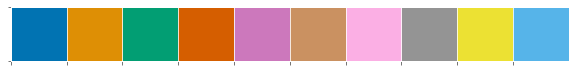

<Figure size 576x288 with 0 Axes>

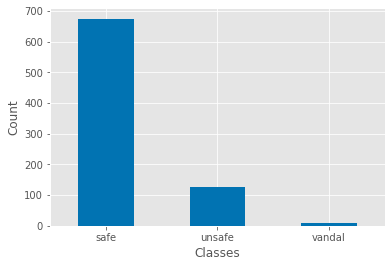

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| label|             comment|          title_page|           name_user|      clean_old_text|      clean_new_text|          difference|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  safe|            map date|201920 coronaviru...|       raphal dunant|redirectcoronavir...|redirectcoronavir...|4  |SEPERATIONLIN...|
|  safe|       typo viawpjwb|yemeni civil war ...|        alistair1978|other usesyemen w...|other usesyemen w...|since the mid-200...|
|unsafe|               empty|                2019|         annettespry|pp-protectedsmall...|pp-protectedsmall...|cameron boyce ame...|
|  safe|2327 marchbroke p...|2020 stock market...|commonknowledgecr...|pp-vandalismsmall...|pp-vandalismsmall...|the bank of japan...|
|  safe|               empty|united states men...|     

In [2]:
%run "preprocessing.ipynb"

In [3]:
# import and clean data: set path correctly 
wiki_df = get_wiki_df(path="../data/subset/*")
clean_df = get_clean_df(wiki_df)

# In order to get the actual difference column
df_with_difference = get_difference_column(clean_df)
final_df = split_difference_into_removed_added(df_with_difference)

In [4]:
def get_stratified_sample(df, fractions, categorical_class="label", random_state = 42):
    """
    This function creates a stratified sample based on thresholds specified on a categorical class
    The aim of this is to balance a dataset more evenly by reducing the size of over-prepresented classes.
    
    Args:
        df: pyspark dataframe with data to be stratified sampled
        fractions: a dictionary of fractions for each category in the categorical variable
        categorical_class: the variable on which to perform stratified sampling
        random_state: default = 42. Set the seed for reproducibility
    Returns:
        df: a pyspark dataframe which has been stratified sampled based on the above criteria.
    """
    auto_fractions = df.select("{}".format(categorical_class)).distinct().withColumn("fraction", lit(1.0)).rdd.collectAsMap()
    #fractions = {'safe': 0.1, 'unsafe': 1.0, 'vandal':1.0}
    # override default 1.0 non-samples with classes which need to be subsampled
    for frac in fractions.items():
        key = frac[0]
        frac_value = frac[1]
        auto_fractions[key] = frac_value
    
    seed = random_state
    sampled_df = df.stat.sampleBy(categorical_class, auto_fractions, seed)
    return sampled_df

## TF-IDF Features on New and Old Texts

Term Frequency - Inverse Document Frequency (TF-IDF) is a technique used to build features out of text documents which have theoretically infinite dimensionality without feature reduction techniques such as this. The term-frequency is the step where we take the tokenized words from the text documents and hash them to a finite feature space. The resulting vectors represent a single document of text. For example, the text 'the brown fox' will hash to a vector of specified length, say 5, such that the result of the hash yields [1,0,2,0,0]. In the case of Spark, the hash used is MurmurHash 3.

However, in a large text corpus, some words will be very present (e.g. “the”, “a”, “is”) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to incorporate the document frequency of occurrence as a weight or normalization to the term-frequencies mentioned above. Hence, TF-IDF.

In [5]:
def tfIdf(df, text_col_for_tf_idf, output_tf_idf_col, count_method = 'hash'):
    
    """ This fucntion takes the text data and converts it into a term frequency-Inverse Document Frequency vector
        The steps for this are tokenization of the input string column, stop word removal, feature hashing/count vectorization depending on 
        the count_method, and inverse document normalization step.
        
    Args: 
        text_col_for_tf_idf: input text column of type 'string' in Java which is used as input to the tokenization, stop word removal and TF-IDF step
        output_tf_idf_col: output column to store the resulting feature
        count_method: default = 'hash'. Determines whether to use featuer hashing or counts as the TF step for TF-IDF
    returns: dataframe with tf-idf vectors

    """

    # Carrying out the Tokenization of the text documents (splitting into words)
    tokenizer = Tokenizer(inputCol=text_col_for_tf_idf, outputCol="tokenised_text")
    tokensDf = tokenizer.transform(df)
    # Carrying out the StopWords Removal for TF-IDF
    stopwordsremover=StopWordsRemover(inputCol='tokenised_text',outputCol='words')
    swremovedDf= stopwordsremover.transform(tokensDf)

    if count_method == 'hash':
        # hashing is irreversible whereas counting is 
        # While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
        # First to compute the IDF vector and second to scale the term frequencies by IDF.
        hashingTF = HashingTF(inputCol="words", outputCol="tf_features")
        tfDf = hashingTF.transform(swremovedDf)
    else:
        # Creating Term Frequency Vector for each word
        cv=CountVectorizer(inputCol="words", outputCol="tf_features", vocabSize=300, minDF=2.0)
        cvModel=cv.fit(swremovedDf)
        tfDf=cvModel.transform(swremovedDf)

    # Carrying out Inverse Document Frequency on the TF data
    # spark.mllib's IDF implementation provides an option for ignoring terms
    # which occur in less than a minimum number of documents.
    # In such cases, the IDF for these terms is set to 0.
    # This feature can be used by passing the minDocFreq value to the IDF constructor.
    idf=IDF(inputCol="tf_features", outputCol="{}".format(output_tf_idf_col))
    idfModel = idf.fit(tfDf)
    tfidfDf = idfModel.transform(tfDf)

    tfidfDf.cache().count()

    return tfidfDf


### Balance Data using Stratified Sampling

We do this to ease the memory usage of the TF-IDF. In any case, the data is highly imbalanced, with a current distribution of:

- safe: 30333 (~86%)
- unsafe: 4136 (~13.2%)
- vandal: 270 (~0.8%)

It is better to rebalance this by subsampling the "safe" class and keeping the others.

In [6]:
sampled_df = get_stratified_sample(df = final_df, fractions = {'safe': 0.15})

In [7]:
get_label_count(sampled_df).show()

+------+--------+
| label|count(1)|
+------+--------+
|unsafe|     126|
|  safe|     102|
|vandal|       9|
+------+--------+



### Calculate TF-IDF via Spark

In [8]:
tfidfDf = tfIdf(sampled_df, text_col_for_tf_idf = "clean_new_text", output_tf_idf_col = "new_text_tf_idf_features")
tfidfDf = tfIdf(tfidfDf, text_col_for_tf_idf = "clean_old_text", output_tf_idf_col = "old_text_tf_idf_features")

IllegalArgumentException: 'Output column tokenised_text already exists.'

## N-Gram Features on Text Differences (Added/Removed)

Here we extract n-gram features from the text differences (text added or removed). The goal is from these simple combinations of words to extract usable features for modelling. Since the words are unordered, an n-gram model is appropriate, as it itself is not necessarily order-preserving in its selection of words.

We select $n = 2$ for simplicity of the method. Additionally, we optionally apply feature hashing to the resulting n-grams.



In [ ]:
def extract_ngrams(df, text_col_for_ngrams, output_col_for_ngrams, n = 2, do_feature_hashing = True):
    """ This fucntion takes a text column and converts it to a (hashed or unhashed) n-gram representation.
        The steps are to remove stop words and to run the n-gram, then do optional feature hashing.
        
    parameter: 
        text_col_for_ngrams: input text column of typ 'string' in Java which is used as input to the stop word removal and n-gram step
        output_col_for_ngrams: output column to store the resulting feature
        n: default = 2. Determines the value of n for the n-gram calculation. Example, n = 1 is a unigram of single words.
        do_feature_hashing: default = True. Determines whether to use featuer hashing or not
    returns: dataframe with n-gram vectors

    """

    ngram = NGram(n=n, inputCol="{}".format(text_col_for_ngrams), outputCol="ngrams")
    df = ngram.transform(df)
    if do_feature_hashing:
        # Carrying out the StopWords Removal for TF-IDF
        stopwordsremover=StopWordsRemover(inputCol='ngrams',outputCol='words')
        swremovedDf= stopwordsremover.transform(df)
        # hashing is irreversible whereas counting is 
        # While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
        # First to compute the IDF vector and second to scale the term frequencies by IDF.
        hashingTF = HashingTF(inputCol="words", outputCol="{}".format(output_col_for_ngrams))
        tfDf = hashingTF.transform(swremovedDf)  
    return tfDf


In [ ]:
tfidfDf = extract_ngrams(tfidfDf, text_col_for_ngrams = "removed_words", output_col_for_ngrams = "removed_words_ngrams_hash_features")
tfidfDf = extract_ngrams(tfidfDf, text_col_for_ngrams = "added_words", output_col_for_ngrams = "added_words_ngrams_hash_features")

### For Pipeline and Modelling

Below you can find a summary of code needed to extract features using these methods